# Brain Tumor Detection
## Resnet101 - Classifier + Regressor
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-16 10:18:51.551801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742120331.559957  177437 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742120331.562439  177437 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742120331.572289  177437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742120331.572305  177437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742120331.572307  177437 computation_placer.cc:177] computation placer alr

In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [4]:
from src.data_handler.data_loader import DataLoader
from src.data_handler.annotation_processor import AnnotationProcessor
from src.data_handler.preprocessor import Preprocessor

In [5]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/-Brain-Tumor-Detection-2/train/


In [7]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [8]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)


IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(CLASS_NAME)

## Dataset Download from Roboflow

In [9]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow(api_key="AAjLIN3PenSZ29LjbI3d")
    project = rf.workspace("yousef-ghanem-jzj4y").project("brain-tumor-detection-fpf1f")
    version = project.version(2)
    dataset = version.download("tensorflow") 

## Load images from directory

In [10]:
prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(6851, 6851, 6851)

In [11]:
train_bboxes[0]

array([[0.68345324, 0.54545455, 0.95683453, 0.76515152],
       [0.42446043, 0.48484848, 0.99280576, 0.96969697],
       [0.46043165, 0.53030303, 0.99280576, 0.78030303]])

In [12]:
train_class_ids

[[0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1],
 [2],
 [1],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [1],
 [0, 1],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2]

In [13]:
train_dl = DataLoader(train_images, train_class_ids, train_bboxes)
train_ds = train_dl.load_train_dataset()
train_ds = Preprocessor(train_ds).preprocess()
train_ds = train_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

I0000 00:00:1742120345.007964  177437 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7211 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [14]:
for batch in train_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(cls[5])
    print(image[1].numpy().min(), image[1].numpy().max())
    for c in cls:
        print(c.numpy())

(32, 240, 240, 3) (32, 3) (32, 3, 4)
tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)
-65.381424 151.061
[0. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]


2025-03-16 10:19:10.739867: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets setup

In [15]:
prepare_valid_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))

valid_image_paths, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(1963, 1963, 1963)

In [ ]:
valid_dl = DataLoader(valid_image_paths, valid_class_ids, valid_bboxes).load_val_dataset()
valid_ds = Preprocessor(valid_dl).preprocess()
valid_ds = valid_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [17]:
for batch in valid_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(image[1].numpy().min(), image[1].numpy().max())

(32, 240, 240, 3) (32, 3) (32, 3, 4)
-123.68 138.49847


2025-03-16 10:19:12.063313: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training Setup

## Define loss

In [18]:
padded_class_ids = train_dl.multi_hot_class_ids
padded_class_ids[:10]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [19]:
from src.losses import binary_weighted_loss as _loss

positive_weights, negative_weights = _loss.compute_class_weights(padded_class_ids)
positive_weights, negative_weights 

(array([0.38140417, 0.01547219, 0.40767771]),
 array([0.61859584, 0.9845278 , 0.5923223 ], dtype=float32))

## Define ResNet50 Model

### Final Model

In [20]:
from src.losses import iou_loss
CLS_METRICS = [
    tf.keras.metrics.AUC(name='AUC', multi_label=True), 
    tf.keras.metrics.F1Score(name='f1_score',average='weighted')]


REG_METRICS = [
    iou_loss.iou_metric,
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),]

### Define  Callbacks

In [21]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec
# 1. Input Schema
# -----------------
# Your input is a batch of images with shape (32, 240, 240, 3)
# We use -1 to indicate that the batch size can vary.
input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, IMG_SIZE, IMG_SIZE, 3), "image")])

# 2. Output Schema - Multilabel binary classification head
# ------------------
# Your model outputs a list of two arrays. We need to define a schema for each.
# Array 1: Shape (1, 3)
output_schema_array1 = TensorSpec(np.dtype(np.float32), (-1, 3), "classification")

# Array 2: Shape (1, 3, 4) - 3 Bounding boxes per classification 
output_schema_array2 = TensorSpec(np.dtype(np.float32), (-1, 3, 4), "bounding_box")

# Create a schema for the list of outputs
output_schema = Schema([output_schema_array1, output_schema_array2])

# 3. Model Signature
# --------------------
# Combine the input and output schemas into a ModelSignature
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [22]:
# import mlflow
# import tensorflow as tf
# from mlflow.models.signature import infer_signature

# # 2. Create hybrid callback
# class SchemaAwareCheckpoint(mlflow.keras.MlflowCallback):
#     def on_epoch_end(self, epoch, logs=None):
#         super().on_epoch_end(epoch, logs)
        
#         if self.save_best_only and logs[to_monitor] == self.best:
#             # Load current best model
#             best_model = tf.keras.models.load_model(
#                 self.filepath,
#                code_paths=["src/losses"],
#             )
            
#             # Re-log model with proper signature
#             mlflow.tensorflow.log_model(
#                 tf_model=best_model,
#                 artifact_path="best_model",
#                 signature=signature,
#                 code_paths=["src/losses"],
#             )
# import mlflow
# import tensorflow as tf
# from mlflow.models.signature import ModelSignature
# from mlflow.types.schema import Schema, TensorSpec
# from tensorflow.keras.callbacks import Callback
# import numpy as np

# class SchemaAwareCheckpoint(Callback):
#     def __init__(self, filepath, monitor='val_loss', mode='auto', save_best_only=False, signature=None, code_paths=None):
#         super().__init__()
#         self.filepath = filepath
#         self.monitor = monitor
#         self.mode = mode
#         self.save_best_only = save_best_only
#         self.signature = signature
#         self.code_paths = code_paths or []

#         if self.mode == 'min':
#             self.best = float('inf')
#         elif self.mode == 'max':
#             self.best = float('-inf')
#         else:
#             raise ValueError(f"Mode {self.mode} is not supported. Please use 'min' or 'max'.")

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         current = logs.get(self.monitor)

#         if current is None:
#             print(f"Warning: {self.monitor} is not available in logs. Cannot save the best model.")
#             return

#         if self.mode == 'min' and current < self.best:
#             self.best = current
#             self.save_model(epoch, logs)
#         elif self.mode == 'max' and current > self.best:
#             self.best = current
#             self.save_model(epoch, logs)

#     def save_model(self, epoch, logs):
#         print(f"\nEpoch {epoch+1}: {self.monitor} improved to {self.best:.4f}. Saving model to MLflow...")
#         # Load current best model
#         best_model = tf.keras.models.load_model(
#             self.filepath,
#             compile=False,
#         )

#         # Re-log model with proper signature
#         mlflow.tensorflow.log_model(
#             tf_model=best_model,
#             artifact_path="best_model",
#             signature=self.signature,
#             code_paths=self.code_paths,
#         )


In [23]:
import os
import mlflow
# to_monitor = 'val_classification_AUC'
# mode = 'max'
to_monitor = 'val_bounding_box_iou_metric'
mode = 'max'
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, 
                                            patience=5, 
                                            monitor=to_monitor,
                                            mode=mode,
                                            min_lr=1e-7,
                                            verbose=1),

    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "detector_ckpt_{epoch}.keras") ,
                                        save_weights_only=False,
                                        save_best_only=True,
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),
                                        
    tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                    patience=10,
                                    mode=mode, 
                                    restore_best_weights=True,
                                    verbose=1),
                                    
    # SchemaAwareCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "detector_ckpt_{epoch}.keras"),
    #                       monitor=to_monitor, 
    #                       mode=mode, 
    #                       save_best_only=True, 
    #                       signature=signature, 
    #                       code_paths=["src/losses"])
    ]

mlflow.set_experiment("/brain-tumor-resnet101-detector")


<Experiment: artifact_location='file:///workspaces/brain-tumor-detection/mlruns/634080561758306152', creation_time=1741959841417, experiment_id='634080561758306152', last_update_time=1741959841417, lifecycle_stage='active', name='/brain-tumor-resnet101-detector', tags={}>

### Define Optimizer

In [24]:
optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

## Model Building and Compilation

In [25]:
from src.models.resnet101 import final_model
tf.keras.backend.clear_session()

model = final_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

model.compile(
    optimizer=optimizer,
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box': iou_loss.iou_loss},
    metrics={'classification': CLS_METRICS, 'bounding_box': REG_METRICS})

model.summary()

Total layers in ResNet101: 345
Unfreezing the last 172 layers (50% of total layers)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_3_c

 Total params: 45,288,847 (172.76 MB)

 Trainable params: 33,268,751 (126.91 MB)

 Non-trainable params: 12,020,096 (45.85 MB)

### Train and Validate the model

In [26]:
with mlflow.start_run() as run:
    mlflow.tensorflow.autolog(log_models=True, 
                          log_datasets=False, 
                          log_input_examples=True,
                          log_model_signatures=True,
                          keras_model_kwargs={"save_format": "keras"},
                          checkpoint_monitor=to_monitor, 
                          checkpoint_mode=mode)
    history = model.fit(
        train_ds,
        epochs=NUM_EPOCHS,
        validation_data=valid_ds,
        batch_size=BATCH_SIZE,
        callbacks=[callbacks],
    )
    mlflow.tensorflow.log_model(
    model,
    "my_model",
    signature=signature,
    code_paths=["src/losses"],
)

2025/03/16 10:19:17 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


I0000 00:00:1742120383.411573  177710 service.cc:152] XLA service 0x77ef54003fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742120383.411634  177710 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-16 10:19:44.186009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742120387.828351  177710 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/215 ━━━━━━━━━━━━━━━━━━━━ 2:29:15 42s/step - bounding_box_iou_metric: 0.0060 - bounding_box_loss: 0.9940 - bounding_box_mae: 0.3389 - bounding_box_mse: 0.1629 - classification_AUC: 0.3179 - classification_f1_score: 0.3886 - classification_loss: 0.7142 - loss: 8.5995

I0000 00:00:1742120399.055677  177710 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - bounding_box_iou_metric: 0.0665 - bounding_box_loss: 0.9335 - bounding_box_mae: 0.3381 - bounding_box_mse: 0.1714 - classification_AUC: 0.6754 - classification_f1_score: 0.5014 - classification_loss: 0.6103 - loss: 7.5061
Epoch 1: val_bounding_box_iou_metric improved from -inf to 0.20069, saving model to output/checkpoints/detector_ckpt_1.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 96s 251ms/step - bounding_box_iou_metric: 0.0667 - bounding_box_loss: 0.9333 - bounding_box_mae: 0.3380 - bounding_box_mse: 0.1713 - classification_AUC: 0.6757 - classification_f1_score: 0.5015 - classification_loss: 0.6100 - loss: 7.5018 - val_bounding_box_iou_metric: 0.2007 - val_bounding_box_loss: 0.8003 - val_bounding_box_mae: 0.2573 - val_bounding_box_mse: 0.1180 - val_classification_AUC: 0.8372 - val_classification_f1_score: 0.4045 - val_classification_loss: 0.5755 - val_loss: 5.0592 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2025/03/16 10:21:02 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/03/16 10:21:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpp_ntzurk/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/16 10:21:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2025/03/16 10:21:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpt5ox9dim/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/16 10:21:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [27]:
# mlflow.tensorflow.log_model(
#     model,
#     "my_model",
#     signature=signature,
#     code_paths=["src/losses"],
# )

In [28]:
model_uri = 'runs:/c1dae6ecb0b74fa7991d58e0eafb13b8/model'
loaded_model = mlflow.tensorflow.load_model(model_uri)

loaded_model.predict(valid_ds)

/code/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 218 variables whereas the saved optimizer has 434 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step


[array([[0.99718434, 0.9941969 , 0.99594784],
        [0.9934847 , 0.9837645 , 0.99242085],
        [0.9851756 , 0.8586661 , 0.93467355],
        ...,
        [0.24637322, 0.54853946, 0.30450255],
        [0.20669077, 0.5322953 , 0.25103167],
        [0.954774  , 0.8636845 , 0.8262473 ]], dtype=float32),
 array([[[0.15233262, 0.6778707 , 0.9758489 , 0.9927786 ],
         [0.09247915, 0.8235257 , 0.9421033 , 0.998386  ],
         [0.35023147, 0.9386748 , 0.973542  , 0.995137  ]],
 
        [[0.13581839, 0.69067127, 0.9550827 , 0.9865226 ],
         [0.06423787, 0.8275129 , 0.92303604, 0.9963568 ],
         [0.36675107, 0.8964282 , 0.9296689 , 0.9933824 ]],
 
        [[0.02916207, 0.20360361, 0.41798168, 0.5588286 ],
         [0.06419933, 0.04848699, 0.55321217, 0.50355947],
         [0.0798517 , 0.12220579, 0.47283673, 0.54547316]],
 
        ...,
 
        [[0.35783443, 0.30800796, 0.7636444 , 0.6545263 ],
         [0.22417916, 0.37972814, 0.7340952 , 0.7268668 ],
         [0.3320949 ,

## Model Evaluation

### Testing Datasets setup

In [29]:
import matplotlib.pyplot as plt

def visualize_training_results(history):
    """
    Visualizes training and validation loss, and training and validation accuracy.

    Args:
        history: A dictionary or object containing training history data.
                 For example, a Keras History object or a dictionary with keys:
                 'loss', 'val_loss', 'accuracy', 'val_accuracy'.
    """

    if isinstance(history, dict):
        # Assumes history is a dictionary
        loss = history.get('loss')
        val_loss = history.get('val_loss')
        accuracy = history.get('accuracy')
        val_accuracy = history.get('val_accuracy')
    else:
        # Assumes history is a Keras History object or similar
        loss = history.history.get('loss')
        val_loss = history.history.get('val_loss')
        accuracy = history.history.get('accuracy')
        val_accuracy = history.history.get('val_accuracy')

    if loss and val_loss:
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(12, 5))

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    if accuracy and val_accuracy:
        if not (loss and val_loss):
          plt.figure(figsize=(12, 5))
        else:
          plt.subplot(1, 2, 2)
        # Plot training & validation accuracy values
        plt.plot(epochs, accuracy, 'r', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout() #prevents overlapping titles/labels
    plt.show()


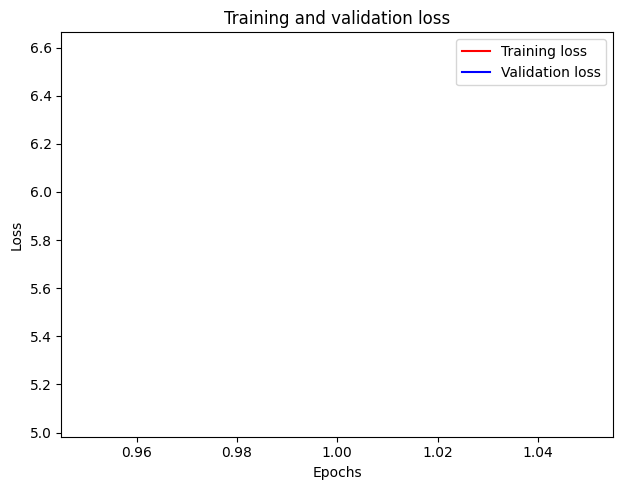

In [30]:
visualize_training_results(history.history)

In [31]:
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(973, 973, 973)

In [32]:
test_dl = DataLoader(test_image_paths, test_class_ids, test_bboxes, img_size=IMG_SIZE)
test_ds = test_dl.load_val_dataset()
y_true_labels = test_dl.multi_hot_class_ids
y_true_bboxes = test_dl.padded_bbx
test_ds = Preprocessor(test_ds).preprocess()
test_ds = test_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [33]:
results = model.evaluate(test_ds, return_dict=True, steps=1)
print("Testing accuracy: ", results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - bounding_box_iou_metric: 0.1946 - bounding_box_loss: 0.8054 - bounding_box_mae: 0.2850 - bounding_box_mse: 0.1412 - classification_AUC: 0.5411 - classification_f1_score: 0.3355 - classification_loss: 0.6712 - loss: 5.1612
Testing accuracy:  {'bounding_box_iou_metric': 0.19459962844848633, 'bounding_box_loss': 0.8054003715515137, 'bounding_box_mae': 0.2850448489189148, 'bounding_box_mse': 0.14115825295448303, 'classification_AUC': 0.5411050319671631, 'classification_f1_score': 0.3355138301849365, 'classification_loss': 0.6712192296981812, 'loss': 5.161164283752441}


In [34]:
results

{'bounding_box_iou_metric': 0.19459962844848633,
 'bounding_box_loss': 0.8054003715515137,
 'bounding_box_mae': 0.2850448489189148,
 'bounding_box_mse': 0.14115825295448303,
 'classification_AUC': 0.5411050319671631,
 'classification_f1_score': 0.3355138301849365,
 'classification_loss': 0.6712192296981812,
 'loss': 5.161164283752441}

In [35]:
from sklearn.metrics import classification_report

y_prob_pred, pred_bbx = model.predict(test_ds)
y_prob_pred[0], pred_bbx[0]

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step


(array([0.85894895, 0.6242209 , 0.8225605 ], dtype=float32),
 array([[0.22292806, 0.7043828 , 0.8153323 , 0.9214853 ],
        [0.2332876 , 0.5193852 , 0.8486597 , 0.9490767 ],
        [0.33692852, 0.740698  , 0.78736424, 0.93114966]], dtype=float32))

In [36]:
y_pred = (y_prob_pred>0.5).astype(int)
y_pred

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [37]:
report = classification_report(y_true_labels, y_pred, labels=[0,1,2], target_names=CLASS_NAME)
print(report)

              precision    recall  f1-score   support

      label0       0.72      0.94      0.81       588
      label1       1.00      0.75      0.86       962
      label2       0.72      0.90      0.80       554

   micro avg       0.81      0.84      0.83      2104
   macro avg       0.81      0.86      0.82      2104
weighted avg       0.85      0.84      0.83      2104
 samples avg       0.70      0.77      0.71      2104



/code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


FileNotFoundError: [Errno 2] No such file or directory: "{'DATASET': {'DATASET_DIR': 'datasets', 'DATASET_NAME': '-Brain-Tumor-Detection-2', 'ANNOTATION_FILE_NAME': '_annotations.csv', 'BONE_FRACTURE_DETECTION_DATASET_URL': 'https://universe.roboflow.com/roboflow-100/brain-tumor-m2pbp/dataset/2#'}, 'DATASET_DIRS': {'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}, 'TRAIN': {'BATCH_SIZE': 32, 'NUM_EPOCHS': 1, 'LEARNING_RATE': 0.0001, 'IMG_SIZE': 240}, 'OUTPUTS': {'OUPUT_DIR': 'output/', 'CONFIG_PIPELINE_PATH': '${OUTPUTS.OUPUT_DIR}/', 'CHECKPOINT_PATH': '${OUTPUTS.OUPUT_DIR}/checkpoints/', 'LOG_DIR': './logs'}}/ROC-Curve.png"

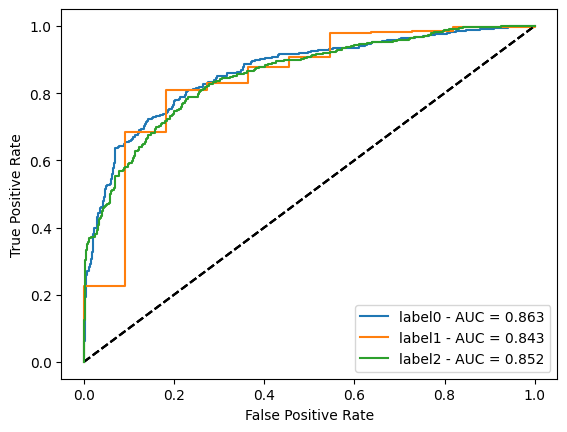

In [38]:
from src.utils.visualization_funcs import plot_auc_curve


plot_auc_curve(cfg, CLASS_NAME, y_true_labels, y_prob_pred)

In [ ]:
test_bboxes

In [ ]:
pred_bbx

In [ ]:
from src.losses.iou_loss import iou_metric
def plot_iou_histogram(y_true_bbox, y_pred_bbox, class_ids):
    """
    Plots a histogram of Intersection over Union (IoU) scores.

    Args:
        y_true_bbox: Ground truth bounding boxes (list of lists or numpy array).
        y_pred_bbox: Predicted bounding boxes (list of lists or numpy array).
        class_ids: list of class ids.
    """
    fig, axs = plt.subplots(1)

    iou_scores = iou_metric(y_true_bbox, y_pred_bbox)

    # fig.figure(figsize=(10, 6))
    axs.hist(iou_scores, bins=20, range=(0, 1), edgecolor='black')
    axs.set_title('IoU Score Distribution')
    axs.set_xlabel('IoU Score')
    axs.set_ylabel('Frequency')
    axs.grid(True)
    plt.show()
    plt.savefig(f"{cfg.OUTPUTS.OUPUT_DIR}/iou_histogram.png")
    return fig


In [ ]:
fig = plot_iou_histogram(y_true_bboxes, pred_bbx, pred_bbx)
mlflow.log_figure(fig, 'iou_histogram.png')